Feature selection to distinguish HER2+ (ERBB2) breast cancer samples


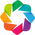

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
hv.extension('bokeh')

import rnaseq_lib as r

## Inputs

In [3]:
# Expression dataframe
df_path = '/mnt/gene-expression-processing/TCGA-GTEx-RSEM-counts-protein-coding.deseq2-normalized.tsv'
%time df = pd.read_csv(df_path, index_col=0, sep='\t')

# Sample Metadata
met_path = '/mnt/rna-seq-analysis/metadata/tcga_gtex_metadata_intersect.tsv'
met = pd.read_csv(met_path, index_col=0, sep='\t')

CPU times: user 5min 37s, sys: 8.21 s, total: 5min 45s
Wall time: 5min 45s


Map gene IDs to names

In [4]:
df.index = r.tissues.map_genes(df.index)

Select breast cancer samples

In [5]:
breast_samples = set(x for x in met[met.tissue == 'Breast'].id if x in df.columns)
g = [x for x in breast_samples if x.startswith('GTEX')]
t = [x for x in breast_samples if x.endswith('01')]
n = [x for x in breast_samples if x.endswith('11')]
len(g), len(t), len(n)

(178, 1090, 112)

Add HER1-4 gene counts to dataframe

In [ ]:
her2 = met[met.id.isin(g + t + n)]
her2['EGFR'] = df.loc['EGFR'].apply(lambda x: np.log2(x + 1))
her2['ERBB2'] = df.loc['ERBB2'].apply(lambda x: np.log2(x + 1))
her2['ERBB3'] = df.loc['ERBB3'].apply(lambda x: np.log2(x + 1))
her2['ERBB4'] = df.loc['ERBB4'].apply(lambda x: np.log2(x + 1))

In [7]:
her2.head(2)

,id,reads,size_MB,platform,sex,tissue,seq_site,weight,height,mapped_reads,race,age,qc,dataset,tumor,type,EGFR,ERBB2,ERBB3,ERBB4
TCGA-A2-A0CL-01,TCGA-A2-A0CL-01,138504314,5722.759744,Illumina HiSeq,female,Breast,UNC,NaN,NaN,135189900.0,black or african american,41.0,6.0,tcga,yes,Breast_Invasive_Carcinoma,10.784109,12.664922,11.054303,5.925214
TCGA-A8-A08G-01,TCGA-A8-A08G-01,189405572,8015.776738,Illumina HiSeq,female,Breast,UNC,NaN,NaN,185876016.0,NaN,42.0,5.6,tcga,yes,Breast_Invasive_Carcinoma,7.864354,14.283273,14.889969,11.181445


## Gene Plots

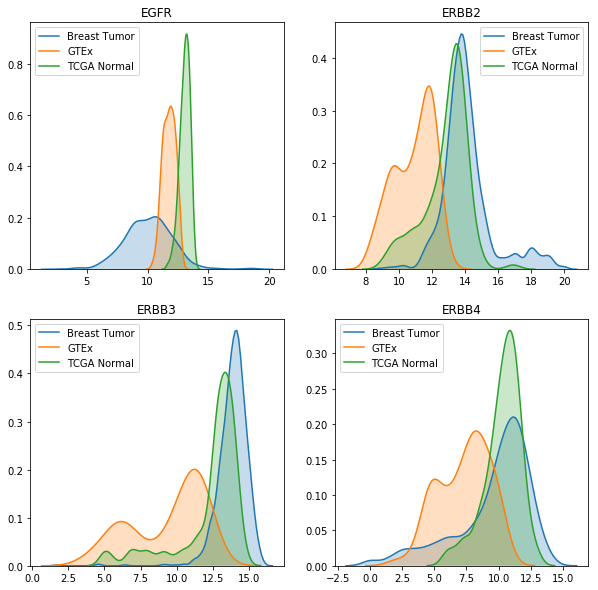

In [8]:
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
for i, gene in enumerate(['EGFR', 'ERBB2', 'ERBB3', 'ERBB4']):
    sns.kdeplot(data=her2.loc[t][gene], label='Breast Tumor', ax=ax[i], shade=True)
    sns.kdeplot(data=her2.loc[g][gene], label='GTEx', ax=ax[i], shade=True)
    sns.kdeplot(data=her2.loc[n][gene], label='TCGA Normal', ax=ax[i], shade=True)
    ax[i].set_title(gene)

## Sample Distribution by Expression

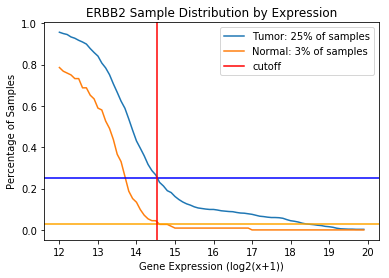

In [9]:
num_t = [len(her2.loc[t][her2.loc[t].ERBB2 > x*.1]) * 1.0 / len(her2.loc[t]) for x in xrange(120, 200)]
num_n = [len(her2.loc[n][her2.loc[n].ERBB2 > x*.1]) * 1.0 / len(her2.loc[n]) for x in xrange(120, 200)]
plt.plot([x*.1 for x in xrange(120, 200)], num_t, label='Tumor: 25% of samples')
plt.plot([x*.1 for x in xrange(120, 200)], num_n, label='Normal: 3% of samples')
plt.axhline(0.25, c='blue')
plt.axhline(0.03, c='orange')
plt.axvline(14.53, c='red', label='cutoff')
plt.xlabel('Gene Expression (log2(x+1))')
plt.ylabel('Percentage of Samples')
plt.legend()
plt.title('ERBB2 Sample Distribution by Expression');

## Feature Selection

In [10]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

Select targeted group based on cutoff

In [11]:
target_group = her2.loc[t][her2.loc[t].ERBB2 > 14.53].index

Add target information to dataframe

In [29]:
her2['target'] = ['Target' if x in target_group else 'Non-Target' for x in her2.index]

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Normalize counts

In [13]:
norm = df.apply(lambda x: np.log2(x + 1))

Subset expression matrix to match her2 dataframe sample order

In [14]:
norm = norm[her2.index]

Plot variance distribution

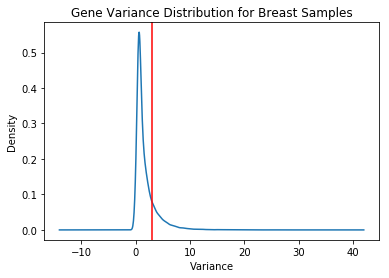

In [15]:
norm.std(axis=1).apply(lambda x: x**2).sort_values().plot(kind='kde')
plt.axvline(3, color='red');
plt.xlabel('Variance')
plt.title('Gene Variance Distribution for Breast Samples');

Remove all low-variance genes

In [16]:
print 'Number of genes: {}'.format(norm.shape[0])
var = norm.loc[norm.std(axis=1)**2 > 3]
print 'After variance threshold: {}'.format(var.shape[0])

Number of genes: 19797
After variance threshold: 3290


Lasso and Select from Model

In [17]:
%%time
clf = LassoCV(max_iter=10000, tol=.01)
sfm = SelectFromModel(clf)
sfm.fit(var.T, her2.target)

CPU times: user 39.7 s, sys: 1.25 s, total: 41 s
Wall time: 39.5 s


In [18]:
print 'Number of features: {}'.format(sfm.transform(var.T).shape[1])

Number of features: 119


Transform matrix

In [19]:
X = sfm.transform(var.T)

Subset expression dataframe down to selected genes

In [20]:
indices = sfm.get_support(indices=True)  # Which columns did we keep?
red_df = var.T.iloc[:, indices]
red_df.head(2)

,PAX7,AMY2A,FLG,BRINP3,C1orf116,KCNJ3,ERMN,DLX1,HOXD4,CXCR1,...,NLRP5,FP565260.2,LOC102724428,B3GALT5,SIK1,SEZ6L,SCUBE1,MAPK8IP2,GRPR,GABRE
TCGA-A2-A0CL-01,8.753645,0.0,3.349777,0.000000,7.425191,11.064146,7.500379,1.721909,5.978782,1.340553,...,0.820683,0.000000,11.822370,11.758077,11.573085,3.237054,4.584197,8.427424,11.568361,10.599796
TCGA-A8-A08G-01,2.677165,0.0,6.188765,1.999194,5.254454,9.885538,5.780305,1.484736,5.826764,2.535164,...,0.677669,4.836906,11.251237,7.304538,8.426032,9.086390,6.580891,11.617220,7.822934,5.631216


## TriMap Plot

In [21]:
%%time
z = r.dim_red.tete(red_df)

CPU times: user 9min 20s, sys: 4.31 s, total: 9min 24s
Wall time: 9min 16s


In [ ]:
her2['x'] = z[:, 0]
her2['y'] = z[:, 1]

In [23]:
her2.head()

,id,reads,size_MB,platform,sex,tissue,seq_site,weight,height,mapped_reads,...,dataset,tumor,type,EGFR,ERBB2,ERBB3,ERBB4,target,x,y
TCGA-A2-A0CL-01,TCGA-A2-A0CL-01,138504314,5722.759744,Illumina HiSeq,female,Breast,UNC,NaN,NaN,135189900.0,...,tcga,yes,Breast_Invasive_Carcinoma,10.784109,12.664922,11.054303,5.925214,0,9.538761,9.448052
TCGA-A8-A08G-01,TCGA-A8-A08G-01,189405572,8015.776738,Illumina HiSeq,female,Breast,UNC,NaN,NaN,185876016.0,...,tcga,yes,Breast_Invasive_Carcinoma,7.864354,14.283273,14.889969,11.181445,0,16.951669,15.193722
TCGA-A2-A0D2-01,TCGA-A2-A0D2-01,139579604,5093.578472,Illumina HiSeq,female,Breast,UNC,NaN,NaN,137017079.0,...,tcga,yes,Breast_Invasive_Carcinoma,10.489735,13.003502,11.980256,5.025497,0,-22.864227,-15.097449
TCGA-A7-A0DB-01,TCGA-A7-A0DB-01,156166804,6020.629615,Illumina HiSeq,female,Breast,UNC,NaN,NaN,149234380.0,...,tcga,yes,Breast_Invasive_Carcinoma,10.002001,11.871543,12.809263,13.686068,0,7.670502,27.501850
TCGA-BH-A0BT-11,TCGA-BH-A0BT-11,128109708,4958.284568,Illumina HiSeq,female,Breast,UNC,NaN,NaN,126268000.0,...,tcga,no,Breast_Invasive_Carcinoma,12.646032,14.083374,13.862623,11.726156,0,-15.317769,22.020918


In [75]:
scatter = hv.Scatter(data=her2, kdims=['x'], vdims=['y', 'target', 'type', 'id', 'ERBB2'])

In [76]:
%%opts Scatter [height=500 width=800 color_index='target']
%%opts Scatter [tools=['hover'] legend_position='left']
%%opts Scatter (cmap='Set1')
%%opts Overlay [tabs=True]
scatter

:Scatter   [x]   (y,target,type,id,ERBB2)

RandomForest

In [62]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [44]:
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

In [45]:
cross_val_score(gbc, var.T, her2.target)

array([ 0.99784483,  0.99568966,  0.99784017])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(var.T, her2.target, test_size=0.2, random_state=42)

In [64]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [77]:
features = pd.Series(gbc.feature_importances_, index=var.index)
features[features > 0]

OXTR        0.001174
EPHB1       0.001342
FAM189A2    0.001677
ALX4        0.002013
CMTM5       0.001677
ERBB2       0.710105
TCEAL5      0.002013
dtype: float64

In [74]:
gbc.score(X_test, y_test)

0.99641577060931896

In [95]:
her2.shape
len(her2)

1391

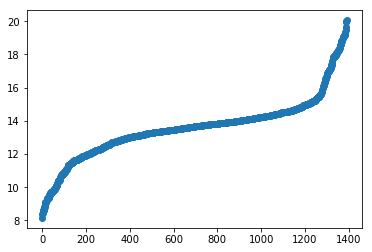

In [100]:
plt.scatter(x=xrange(len(her2)), y=her2.sort_values('ERBB2').ERBB2)

## ERBB2 Across Tissues

In [143]:
tissues = ['Adrenal', 'Bladder', 'Brain', 'Breast', 'Cervix', 'Colon', 'Esophagus', 
          'Head', 'Kidney', 'Liver', 'Lung', 'Pancreas', 'Prostate', 'Skin', 'Small_intestine', 
           'Spleen', 'Stomach', 'Testis', 'Thyroid', 'Uterus']

Subset by selected tissues, then by samples in the expression dataset

In [139]:
sub = met[met.tissue.isin(tissues)].sort_values('tissue')

samples = set(x for x in sub.id if x in df.columns)
sub = sub[sub.id.isin(samples)]

Plot

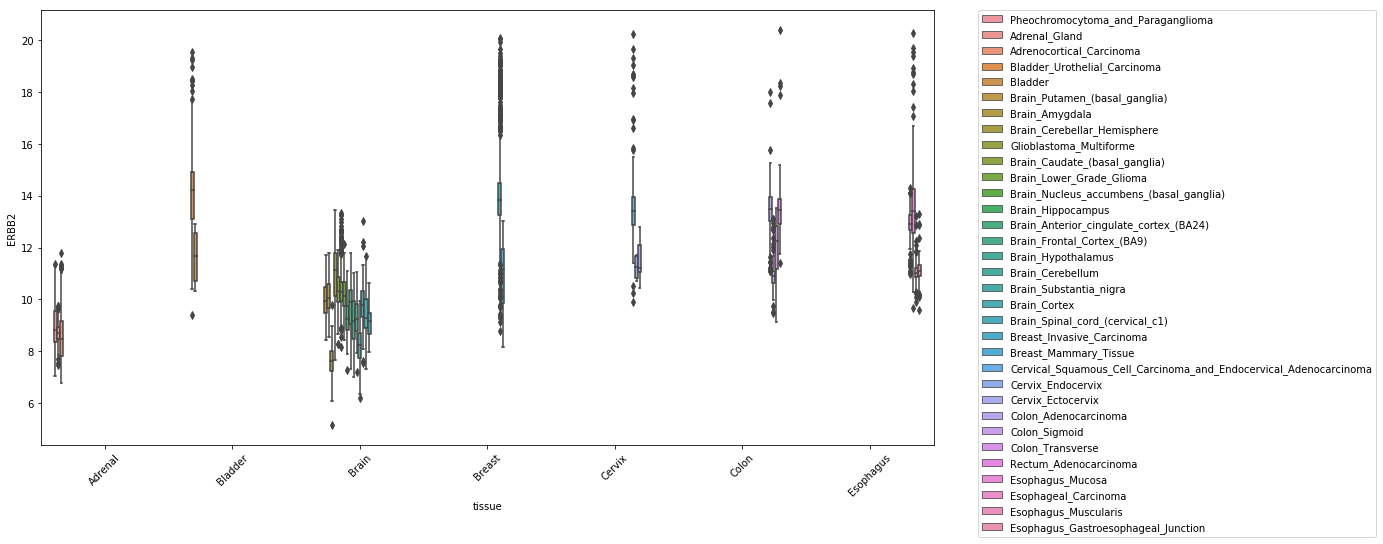

In [141]:
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=sub, x='tissue', y='ERBB2', ax=ax, hue='type', order=tissues)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45);

In [158]:
for i, j in g.id.count().iteritems():
    print i, j

Adrenal_Gland 159
Adrenocortical_Carcinoma 79
Pheochromocytoma_and_Paraganglioma 187


In [155]:
samples = {}
for tissue in tissues:
    sub = met[met.tissue == tissue]
    g = sub.groupby('type')
    for t, num_samples in g.id.count().iteritems():
        print t, num_samples
    break

TypeError: 'numpy.int64' object is not iterable